In [1]:
# Generic imports
from __future__ import print_function
import numpy as np
from Bio import SeqIO

In [17]:
#Machine learning/Stats imports 
#from scipy.stats import norm
#from scipy.stats import spearmanr,pearsonr
#from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Activation
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.engine.topology import Layer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

In [3]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

In [4]:
def filter_seq(seq):
    '''Filter away ambiguous character containing sequences.'''
    if set(list(seq)) <= AA_SET:
        return(seq)
    else:
        return(None)

In [5]:
def seq2onehot(seq_list):
    '''
    Translate a list of amino acid sequences into a 3D tensor with onehot encodings.
    NB. all sequences must be of equal length.
    '''
    seqlen = len(seq_list[0])
    assert(not [True for s in seq_list if len(s) != seqlen])
    onehot_tensor = np.zeros((len(seq_list), seqlen, len(AA_SET)))
    for i, seq in enumerate(seq_list):
        for j, a in enumerate(seq):
            onehot_tensor[i][j][AA_DICT[a]] = 1
    return(onehot_tensor)

In [6]:
def onehot2seq(onehot_tensor):
    '''
    Translate a 3D tensor with onehot encodings to a list of amino acid sequences.
    '''
    seq_list = list()
    for i in range(onehot_tensor.shape[0]):
        seq = list()
        for j in range(onehot_tensor.shape[1]):
            seq.append(AA_DICT_REV[onehot_tensor[i][j].argmax()])
        seq_list.append(''.join(seq))
    return(seq_list)

In [15]:
# Read in some sequences:
MAX_SEQS = 100  # Though example.fasta only has 10 sequences 
fnam = 'example.fasta'  # These are just randomly generated sequences
seq_list = list()
for i, record in enumerate(SeqIO.parse(fnam, 'fasta')):
    if i >= MAX_SEQS:
        break
    seq = str(record.seq)
    if len(seq_list) > 0:
        assert(len(seq_list[-1]) == len(seq))
    seq_list.append(seq)

print('Input data has {} sequences.'.format(len(seq_list)))
print('This is how the first sequence looks like:\n{}'.format(seq_list[0]))

Input data has 10 sequences.
This is how the first sequence looks like:
HYMVCRCFLSRPPSEDHYYRWRMGVEKDPNQFYQYKCPYWKNCKIKFQMGRCQVQQCIKREYCSVMKIPGYTVHWHKTFHKWGMFKFWKHSFFNSNYWHVDGLCRQMNWIRLYVSGIVNNWMLYHNHMTANVVMPRVRIMNHWCEIYEVEPQTCMMTGNYCWFSVDPYYVTHGHPYEPTCYMKMGKKIAYAEMCCARCWAKARDIFTTLRRNMDMPGYLVVKIYPIMEATMYDHYQQD


In [16]:
# Transform to onehot:
onehot_tensor = seq2onehot(seq_list)
print('Onehot encoded tensor has this shape: {}'.format(onehot_tensor.shape))

Onehot encoded tensor has this shape: (10, 238, 20)


In [19]:
# Here we define the new layers necessary to reconstruct the model:
class CompositeResidue(Layer):
    '''
    This is the "Composite Residue" layer.
    The input sets the number of residues to group.
    '''
    def __init__(self, Ncomp, **kwargs):
        self.Ncomp = Ncomp
        super(CompositeResidue, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.Ncomp),
                                      initializer='uniform',
                                      trainable=True)
        super(CompositeResidue, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(K.permute_dimensions(x, (0,2,1)), self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2], self.Ncomp)


class OnehotEmbedding(Layer):
    '''
    This is an alternative to the normal keras embedding layer
    which works on categorical data. This provides the same functionality
    but on a onehot encoding of the categorical data.
    '''
    def __init__(self, Nembeddings, **kwargs):
        self.Nembeddings = Nembeddings
        super(OnehotEmbedding, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[2], self.Nembeddings),
                                      initializer='uniform',
                                      trainable=True)
        super(OnehotEmbedding, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.Nembeddings)

In [22]:
# Various network definitions:
batch_size = 1
input_shape = onehot_tensor.shape[1:]
embedding_output_dim = 15  # As defined in the article
N_composite_residue = 5    # As defined in the article
dense_nodes = 5            # As defined in the article
output_dim = 1             # As defined in the article

In [24]:
# The model is defined:
CR_input = Input(shape=input_shape)
embedding = OnehotEmbedding(embedding_output_dim)(CR_input)
CR_layer = CompositeResidue(N_composite_residue)(embedding)
CR_flat = Flatten()(CR_layer)
CR_act = Activation('selu')(CR_flat)
dense1 = Dense(dense_nodes, activation='selu', use_bias=False)(CR_act)
CR_output = Dense(output_dim, use_bias=True)(dense1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 238, 20)           0         
_________________________________________________________________
onehot_embedding_2 (OnehotEm (None, 238, 15)           300       
_________________________________________________________________
composite_residue_2 (Composi (None, 15, 5)             1190      
_________________________________________________________________
flatten_2 (Flatten)          (None, 75)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 375       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total para

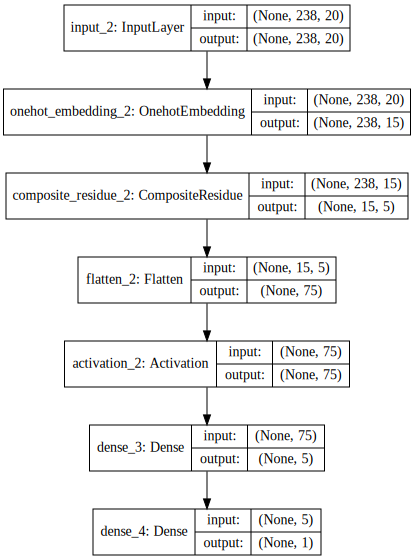

In [26]:
# The model is setup and visualized:
model = Model(CR_input, CR_output)
model.summary()
plot_model(model, show_shapes=True, to_file='keras_model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))